In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from configparser import ConfigParser
import pandas as pd
import numpy as np
import pickle
import os
import re
import gc
import csv
import seaborn as sns
#from rfpimp import permutation_importances
import warnings
from tqdm import tqdm
from time import gmtime, strftime
from io import StringIO
import psycopg2.extras as extras
from sklearn.feature_selection import VarianceThreshold
#import dill
warnings.filterwarnings('ignore')
#shap.initjs()
pd.options.display.max_columns=1000
pd.options.display.max_rows=1000

In [28]:
#os.getcwd()
#Setting data directory
filepath='C:\\Users\\schilloji\\OneDrive - VMware, Inc\\Personal\\IIM C APDS\\APDS Course\\iim_apds_churn_prjct\\data\\Telecom_customer_churn.csv'

In [29]:
#Define missing values.
def missing_values_with_ther(df,perc):
    #Total missing values
    mis_val=df.isnull().sum()
    mis_val=pd.DataFrame({'Column_Name':mis_val.index,'Missing_value':mis_val.values})
    #Percentage missing value
    mis_val_percent=100*df.isnull().sum()/len(df)
    mis_val_percent=pd.DataFrame({'Column_Name':mis_val_percent.index,'Perc_of_Total_values':mis_val_percent.values})
    #table with results
    mis_val_table=pd.concat([mis_val,mis_val_percent],axis=1,ignore_index=True)
    #rename and select required columns
    mis_val_table_with_column=mis_val_table.rename(columns=
                                                  {0:'Column_Name',1:'Missing_value',3:'Perc_of_Total_values'})
    mis_val_table_with_column=mis_val_table_with_column[['Column_Name','Missing_value','Perc_of_Total_values']]
    
    #Sort tabels by %of columns.
    mis_val_table_with_column=mis_val_table_with_column[mis_val_table_with_column.iloc[:,1]!=0].sort_values(
        'Perc_of_Total_values',ascending=False).round(1)
    
    mis_val_table_with_column=mis_val_table_with_column[mis_val_table_with_column['Perc_of_Total_values']>perc]
    
    #print summary infromation
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_with_column.shape[0]) +
              " columns that have missing values greater than " + str(perc) + " Percentage")
    return mis_val_table_with_column

#Define missing values.
def missing_values(df):
    #Total missing values
    mis_val=df.isnull().sum()
    mis_val=pd.DataFrame({'Column_Name':mis_val.index,'Missing_value':mis_val.values})
    #Percentage missing value
    mis_val_percent=100*df.isnull().sum()/len(df)
    mis_val_percent=pd.DataFrame({'Column_Name':mis_val_percent.index,'Perc_of_Total_values':mis_val_percent.values})
    #table with results
    mis_val_table=pd.concat([mis_val,mis_val_percent],axis=1,ignore_index=True)
    #rename and select required columns
    mis_val_table_with_column=mis_val_table.rename(columns=
                                                  {0:'Column_Name',1:'Missing_value',3:'Perc_of_Total_values'})
    mis_val_table_with_column=mis_val_table_with_column[['Column_Name','Missing_value','Perc_of_Total_values']]
    
    #Sort tabels by %of columns.
    mis_val_table_with_column=mis_val_table_with_column[mis_val_table_with_column.iloc[:,1]!=0].sort_values(
        'Perc_of_Total_values',ascending=False).round(1)
    
    #mis_val_table_with_column=mis_val_table_with_column[mis_val_table_with_column['Perc_of_Total_values']>perc]
    
    #print summary infromation
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_with_column.shape[0]) +
              " columns that have missing values.")
    return mis_val_table_with_column


# Removal of Zero Variance Columns
def rem_var(df,ther):
    numeric_df=df.select_dtypes(exclude='object')
    numeric_df=numeric_df[numeric_df.columns.drop(list(['churn']))]
    
    #Remove near zero variance columns
    selector=VarianceThreshold(ther)
    selector.fit(numeric_df)
    
    numeric_df_1=df[numeric_df.columns[selector.get_support(indices=True)]]
    
    print ("Your selected dataframe has " + str(numeric_df.shape[1]) + " columns.\n"      
           "Your selected dataframe has " + str(numeric_df.shape[1]) + " Numerical columns.\n" 
            "There are " + str(numeric_df_1.shape[1]) +" columns has variance greater than " + str(ther) + " Percentage")
      
    object_df = df.select_dtypes(include='object')
    
    df_1 = pd.concat([df[object_df.columns],numeric_df_1, df['churn']], axis=1)
    
    return df_1

def corelated(df,val):
    
    #Only Numerical columns
    numeric_df=df.select_dtypes(exclude='object')
    numeric_df=numeric_df[numeric_df.columns.drop(list(['churn']))]
    
    # Create correlation matrix
    corr_matrix = numeric_df.corr()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > val)]
    numeric_df_1 = numeric_df.drop(to_drop, axis=1)
    
    #Categorical Columns
    object_df = df.select_dtypes(include='object')
    df_1 = pd.concat([df[object_df.columns],numeric_df_1, df['churn']], axis=1)

    gc.enable()
    del corr_matrix
    gc.collect()
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "In that dataframe has " + str(numeric_df.shape[1]) + " Numerical columns.\n"
           "There are " + str(len(to_drop)) +" columns has correlation greater than " + str(val) + " Percentage")
    
    print(numeric_df_1.shape)
    return df_1


def data_outlier(df,low_cut,high_cut):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_col=df[df.columns.drop(list(['churn','Customer_ID']))].select_dtypes(include=numerics).columns
    i=0
    for i in range(len(numeric_col)):
        column=numeric_col[i]
        df.loc[df[column]>df[column].quantile(high_cut),column]=df[column].quantile(high_cut)
        df.loc[df[column]<df[column].quantile(low_cut),column]=df[column].quantile(low_cut)

In [30]:
telo_df=pd.read_csv(filepath)
telo_df.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [31]:
missing_values_with_ther(telo_df,10)

Your selected dataframe has 100 columns.
There are 10 columns that have missing values greater than 10 Percentage


,Column_Name,Missing_value,Perc_of_Total_values
87,numbcars,49366,49.4
89,dwllsize,38308,38.3
88,HHstatin,37923,37.9
80,ownrent,33706,33.7
82,dwlltype,31909,31.9
81,lor,30190,30.2
86,income,25436,25.4
84,adults,23019,23.0
85,infobase,22079,22.1
77,hnd_webcap,10189,10.2


In [32]:
#Imputing mean for the numerical variables.
telo_df_missing=missing_values(telo_df)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_col=telo_df[telo_df_missing['Column_Name']].select_dtypes(include=numerics).columns
telo_df[numeric_col]=telo_df[numeric_col].fillna(telo_df[numeric_col].mean())
print(telo_df.shape)

Your selected dataframe has 100 columns.
There are 43 columns that have missing values.
(100000, 100)


In [33]:
missing_values(telo_df)

Your selected dataframe has 100 columns.
There are 18 columns that have missing values.


,Column_Name,Missing_value,Perc_of_Total_values
89,dwllsize,38308,38.3
88,HHstatin,37923,37.9
80,ownrent,33706,33.7
82,dwlltype,31909,31.9
85,infobase,22079,22.1
77,hnd_webcap,10189,10.2
70,prizm_social_one,7388,7.4
83,marital,1732,1.7
91,ethnic,1732,1.7
92,kid0_2,1732,1.7


In [34]:
def plot(df,column,low_cut,high_cut):
    #Box plot to under stand the ouliers

    f, axes = plt.subplots(ncols=2,nrows=1,figsize=(17,6))
    sns.set(style="whitegrid")
    #sns.boxplot(df.column,ax=axes[0])

    #sns.distplot(df.column.dropna(),ax=axes[1])

    sns.boxplot(df[(df[column]>df[column].quantile(low_cut))&
              (df[column]<df[column].quantile(high_cut))][column].dropna(),ax=axes[0])

    sns.distplot(df[(df[column]>df[column].quantile(low_cut))&
              (df[column]<df[column].quantile(high_cut))][column].dropna(),ax=axes[1])

#plot(telo_df,'totmrc_Mean',0.05,0.95)

# Removing the top 5% and bottom 5% of the outliers
data_outlier(telo_df,0.05,0.95)

In [41]:
#Filling as Missing for categorical variables.
telo_df.fillna('Missing',inplace=True)
missing_values(telo_df)
print(telo_df.shape)
gc.collect()

Your selected dataframe has 100 columns.
There are 0 columns that have missing values.
(100000, 100)


32818

In [45]:
#churn_df.select_dtypes('object').apply(pd.Series.nunique,axis=0)


telo_df.select_dtypes('object').apply(pd.Series.nunique,axis=0)

new_cell             3
crclscod            54
asl_flag             2
prizm_social_one     6
area                20
dualband             5
refurb_new           3
hnd_webcap           4
ownrent              3
dwlltype             3
marital              6
infobase             3
HHstatin             7
dwllsize            16
ethnic              18
kid0_2               3
kid3_5               3
kid6_10              3
kid11_15             3
kid16_17             3
creditcd             3
dtype: int64

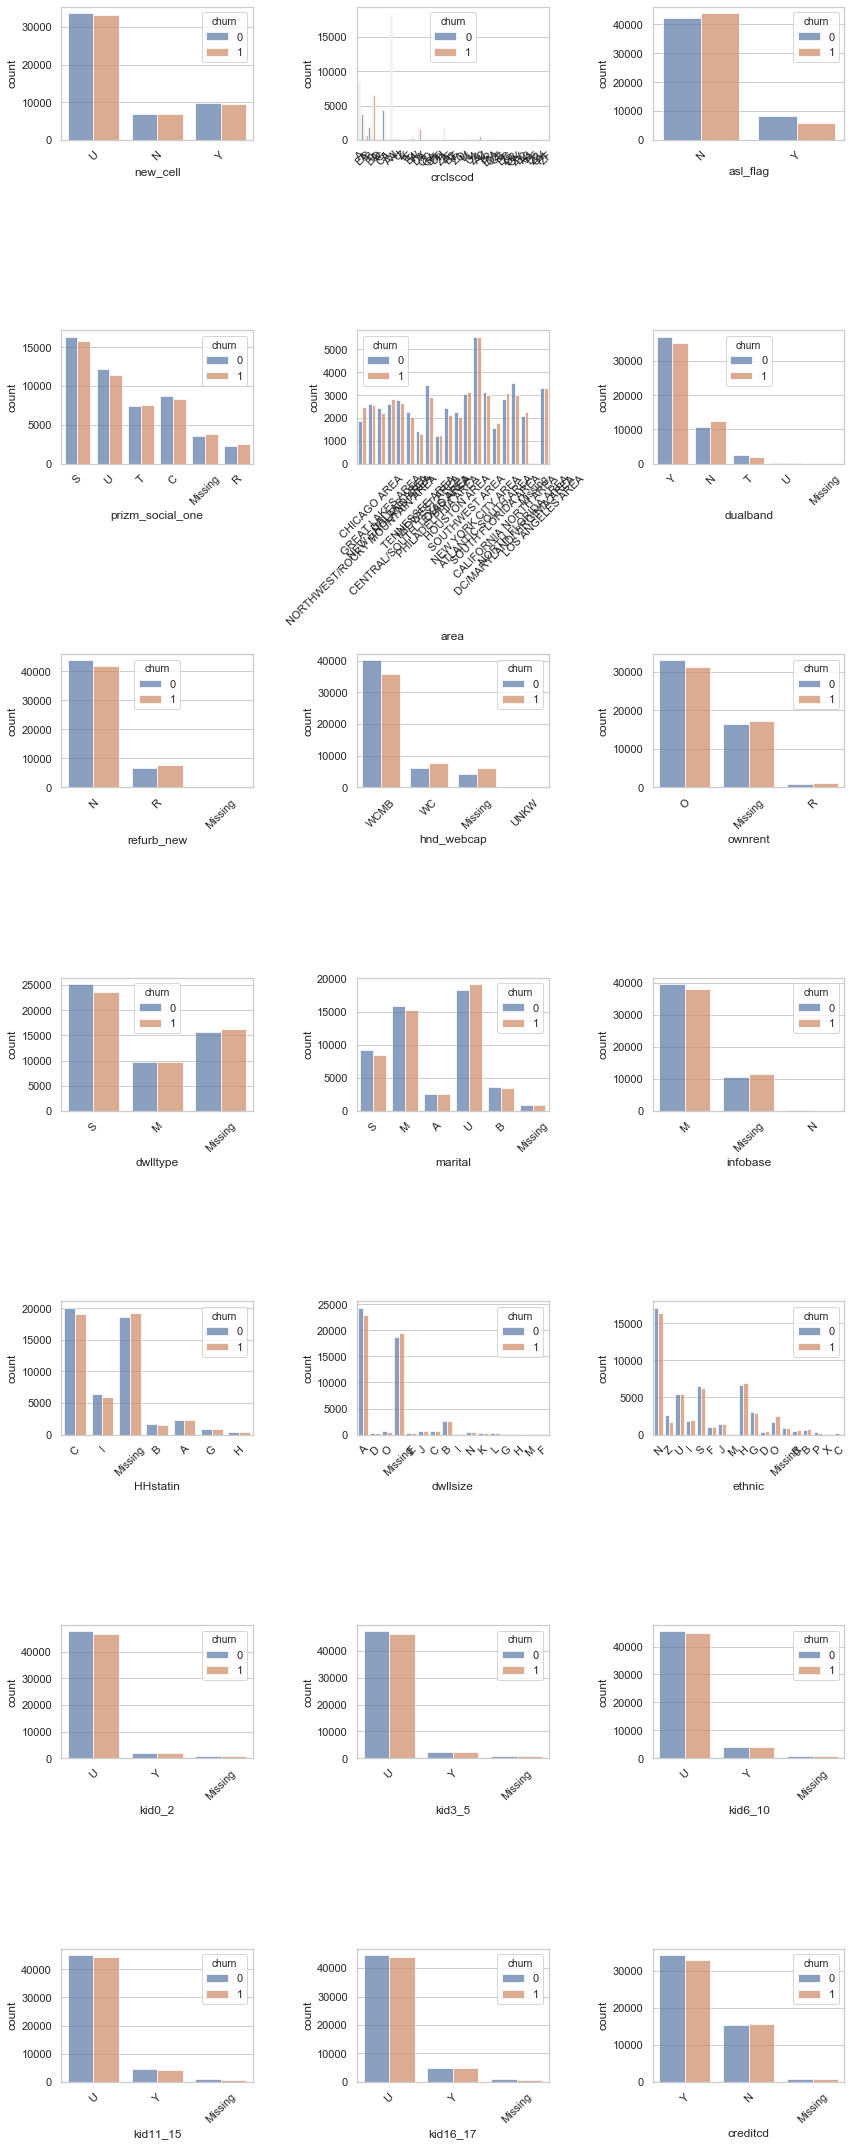

In [47]:
#Exploration of categorical varaible
categ_col = telo_df.select_dtypes(include = ['object'])
telo_df_cat=pd.concat([categ_col,telo_df['churn']],axis=1)
telo_df_cat.head()

fig, axes = plt.subplots(round(len(telo_df_cat.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(telo_df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=telo_df_cat.columns[i],hue='churn', alpha=0.7, data=telo_df_cat, ax=ax)

fig.tight_layout()